# 🍭 [Day 17](https://adventofcode.com/2019/day/17)

In [1]:
def run_program(p, inputs, init_op=0, init_base=0):
    """Intcode as usual"""
    #Inputs are given in reverse order (pop)
    op = init_op
    relative_base = init_base
    last_diagnostic = []
    while p[op] != 99:
        codes = "%05d" % p[op]
        codes = [int(codes[0]), int(codes[1]), int(codes[2]), int(codes[3:])]
        # inputs
        if codes[-1] == 3:
            if not len(inputs):
                # Game is waiting for next move
                break
            assert codes[1] == 0
            p[p[op + 1] + (relative_base if codes[2] == 2 else 0)] = inputs.pop()
            op += 2
        # unary ops
        elif codes[-1] in  [4, 9]:
            # read parameter
            assert codes[1] == 0
            param = p[op + 1]
            if (codes[2] % 2) == 0:
                try:
                    param = p[param + (relative_base if codes[2] == 2 else 0)]
                except IndexError:
                    param = 0
            # output
            if codes[-1] == 4:
                last_diagnostic.append(param)
            # update relative base
            else:
                relative_base += param
            # next instr
            op += 2
        else:
            # read parameters in correct mode
            x, y = p[op + 1:op + 3]
            if (codes[2] % 2) == 0:
                try:
                    x = p[x + (relative_base if codes[2] == 2 else 0)]
                except IndexError:
                    x = 0
            if not (codes[1] % 2):
                try:
                    y = p[y + (relative_base if codes[1] == 2 else 0)]
                except IndexError:
                    y = 0
            # Read target and allocate more memory if needed
            target = p[op + 3] + (relative_base if codes[0] == 2 else 0)
            if target >= len(p): 
                p += [0] * (target - len(p) + 1)
            # addition and multiplication
            if codes[-1] in [1, 2]:
                p[target] = x + y if codes[-1] == 1 else x * y
                op += 4
            # Comparison result
            elif codes[-1] == 7:
                p[target] = int(x < y)
                op += 4
            elif codes[-1] == 8:
                p[target] = int(x == y)
                op += 4
            # Jump if eq
            elif (codes[-1] == 5 and x != 0) or (codes[-1] == 6 and x == 0):
                op = y  
            # Jump instruction that failed their test
            else:
                op += 3
    return last_diagnostic, 0, op, relative_base


import numpy as np
def build_map(program):
    """Parse inputs"""
    p = [x for x in program]
    outputs = run_program(p, [])[0]
    grid = [[]]
    for c in outputs:
        if c == 46:
            grid[-1].append(0)
        elif c == 35:
            grid[-1].append(1)
        elif c  == 10:
            grid.append([])
        else:
            print("Initial robot direction:", chr(c))
            grid[-1].append(2)
    return np.array(grid[:-2], dtype=np.int32)


from matplotlib import pyplot as plt
def display_grid(grid, title=None):
    plt.imshow(grid.transpose(), cmap='Accent_r')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()


def convolve2d(matrix, kernel):
    """Basic 2d convolutions"""
    lkw = int(np.ceil((kernel.shape[0] - 1) / 2))
    lkh = int(np.ceil((kernel.shape[1] - 1) / 2))
    conv = np.zeros_like(matrix)
    # Pad 
    padded_matrix = np.pad(matrix, 
                           ((lkw, kernel.shape[0] - lkw),
                            (lkh, kernel.shape[1] - lkh)),
                            'constant')
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            conv[i, j] = np.sum(kernel * padded_matrix[i:i+kernel.shape[0], 
                                                       j:j+kernel.shape[1]])
    return conv

def get_alignment(grid):
    """Find intersections with a convolution"""
    flt = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    convolution = convolve2d(grid, flt)
    intersects = np.where(convolution == 5)
    alignment = sum([i * j for i, j in zip(*intersects)])
    return alignment


def get_path(grid, display=False):
    """Find the path that goes through all scaffolds"""
    robot = np.where(grid == 2)
    i, j = robot[0][0], robot[1][0]
    path = []
    if display:
        plot = np.zeros_like(grid)
        plot[i, j] = 100
    
    # Distinguish between orientation
    # and move commands
    o = (0, -1)
    def find_nxt_move():
        nonlocal i, j, o, grid
        for new_o in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            if (o[0] * new_o[0]) or (o[1] * new_o[1]): # Can not go back or forth in same direction 
                continue
                
            if ((i + new_o[0] >= 0 and i + new_o[0] < grid.shape[0]) and 
                (j + new_o[1] >= 0 and j + new_o[1] < grid.shape[0]) and
                grid[i + new_o[0], j + new_o[1]] == 1):
                    # Resolve
                    if o[1] == -1:
                        move = 'R' if new_o[0] == 1 else 'L'
                    elif o[1] == 1:
                        move = 'R' if new_o[0] == -1 else 'L'
                    elif o[0] == 1:
                        move = 'R' if new_o[1] == 1 else 'L'
                    elif o[0] == -1:
                        move = 'R' if new_o[1] == -1 else 'L'
                    # Assign new orientation
                    o = new_o
                    return move
        o = None
        
    # Find the path in a greedy manner
    forward = 0
    while o != None:
        # Go forward until falling down
        while ((i >= 0 and i < grid.shape[0]) and 
               (j >= 0 and j < grid.shape[1]) and 
               grid[i, j] != 0):
            if display:
                plot[i, j] = 60 if len(path) == 0 else 30 if path[-1] == 'L' else 50
            i += o[0]
            j += o[1]
            forward += 1
        # One step back
        i -= o[0]
        j -= o[1]
        forward -= 1
        if forward:
            path.append(forward)
        # Check for next move
        path.append(find_nxt_move())
        forward = 0
    if display:
        display_grid(grid, "Original map")
        display_grid(plot, "Path")
    return path[:-1]

In [2]:
with open("inputs/day17.txt", 'r') as f:
    inputs = list(map(int, f.read().split(',')))
    grid = build_map(inputs).transpose()

print("The sum of camera alignment paremeters is {}".format(get_alignment(grid)))

Initial robot direction: ^
The sum of camera alignment paremeters is 4220


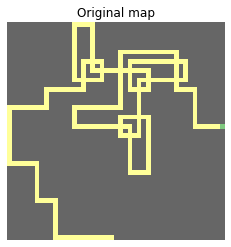

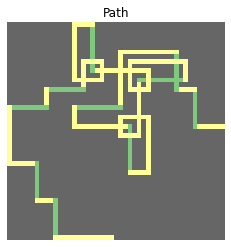

L,6,R,8,L,4,R,8,L,12,L,12,R,10,L,4,L,12,R,10,L,4,L,12,L,6,L,4,L,4,L,12,R,10,L,4,L,12,L,6,L,4,L,4,L,12,R,10,L,4,L,12,L,6,L,4,L,4,L,6,R,8,L,4,R,8,L,12,L,6,R,8,L,4,R,8,L,12


In [3]:
# First we find the path, then we want to decompose it 
# into iterations of three subroutines, which each should
# be described in at most 20 characters (~5 - 6 turns)
path = get_path(grid, display=True)
print(",".join(list(map(str, path))))

In [4]:
 def find_subpattern(path, max_char=20):
    """Find repetitions of the prefix of the path inside path itself"""
    l = 0
    i = 0
    candidate = []
    while i < len(path): 
        l += len(str(path[i])) + 1 # + 1 for comma
        if l > max_char + 1:
            break
        candidate.append(path[i])
        i += 1
        
    # See how many times each substrings repeat
    num_chars = len(candidate)
    repeats = [{} for _ in range(len(candidate))]
    for i, c in enumerate(path):
        for j in range(num_chars):
            if (j == 0 or i - 1 in repeats[j - 1]) and path[i] == candidate[j]:
                repeats[j][i] = True
    return sorted([(candidate[:j+1], list(repeats[j].keys())) for j in range(num_chars)],
                  key= lambda x: len(x[0]))


def select_subpattern(path, candidate):
    """Higlight substrings that match the return value of find_subpattern"""
    print("Selected candidate", ''.join(list(map(str, candidate[0]))))
    num_chars = len(candidate[0])
    # highlight the selected pattern
    i = 0
    s = ''
    for i1 in candidate[1]: # i1 index is included in pattern
        s += '{}\033[91m{}\033[0m'.format(''.join(list(map(str, path[i:i1+1-num_chars]))),
                                          ''.join(list(map(str, path[i1+1-num_chars:i1+1]))))
        i = i1 + 1
    s += ''.join(list(map(str, path[i:])))
    print(s)
    
 
## partially manual solution
print("\n\n\033[1mPath:\033[0m")
print(''.join(list(map(str, path))))

# Let's ignore the first character, because in the worst case 
# we can always repeat a routine of one steps forward infinitel
    
print("\n\n\033[1mFind first subpattern:\033[0m")
candidates = find_subpattern(path)
print('\n'.join('  ({} repeats): {}'.format(
    len(ins), ''.join(list(map(str, c)))) 
                for c, ins in candidates))
candidate = candidates[-1] # handpicked
select_subpattern(path, candidate)

print("\n\n\033[1mFind second subpattern in split paths:\033[0m")

subpath = path[candidate[1][0] + 1:candidate[1][1] - len(candidate[0])]
print(''.join(list(map(str, subpath))))
candidates = find_subpattern(subpath)
print('\n'.join('  ({} repeats): {}'.format(
    len(ins), ''.join(list(map(str, c)))) 
                for c, ins in candidates))
candidate = candidates[5] # handpicked
select_subpattern(subpath, candidate)


print("\nIt's then pretty clear that the remaining pattern is 'L12L6L4L4'.")
print("So the final routine is A,B,B,C,B,C,B,C,A,A ")
print("where A = L6R8L4R8L12\n      B = L12R10L4\n      C = L12L6L4L4")



Path:
L6R8L4R8L12L12R10L4L12R10L4L12L6L4L4L12R10L4L12L6L4L4L12R10L4L12L6L4L4L6R8L4R8L12L6R8L4R8L12


Find first subpattern:
  (29 repeats): L
  (6 repeats): L6
  (3 repeats): L6R
  (3 repeats): L6R8
  (3 repeats): L6R8L
  (3 repeats): L6R8L4
  (3 repeats): L6R8L4R
  (3 repeats): L6R8L4R8
  (3 repeats): L6R8L4R8L
  (3 repeats): L6R8L4R8L12
Selected candidate L6R8L4R8L12
L6R8L4R8L12L12R10L4L12R10L4L12L6L4L4L12R10L4L12L6L4L4L12R10L4L12L6L4L4L6R8L4R8L12L6R8L4R8L12


Find second subpattern in split paths:
L12R10L4L12R10L4L12L6L4L4L12R10L4L12L6L4L4L12R10L4L12L6L4L
  (20 repeats): L
  (7 repeats): L12
  (4 repeats): L12R
  (4 repeats): L12R10
  (4 repeats): L12R10L
  (4 repeats): L12R10L4
  (4 repeats): L12R10L4L
  (4 repeats): L12R10L4L12
  (1 repeats): L12R10L4L12R
Selected candidate L12R10L4
L12R10L4L12R10L4L12L6L4L4L12R10L4L12L6L4L4L12R10L4L12L6L4L

It's then pretty clear that the remaining pattern is 'L12L6L4L4'.
So the final routine is A,B,B,C,B,C,B,C,A,A 
where A = L6R8L4R8L12
      

In [5]:
# Finally it's time to run the code
routine = [ord(x) for x in "A,B,B,C,B,C,B,C,A,A"] + [10]
A = [ord(x) for x in "L,6,R,8,L,4,R,8,L,12"] + [10]
B = [ord(x) for x in "L,12,R,10,L,4"] + [10]
C = [ord(x) for x in "L,12,L,6,L,4,L,4"] + [10]
commands = routine + A + B + C + [ord('n'), 10]

with open("inputs/day17.txt", 'r') as f:
    inputs = list(map(int, f.read().split(',')))
p = [x for x in inputs]
p[0] = 2
print("A total of {} dust particles were collected".format(run_program(p, commands[::-1])[0][-1]))

A total of 809736 dust particles were collected
